导入库

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from utils import *
from conv import *
from relu import *
from concat import *
from bias import b_conv1,b_conv2,b_conv3,b_conv4,b_conv5
from weights import w_conv1,w_conv2,w_conv3,w_conv4,w_conv5
print("w_conv1:",w_conv1.shape)
print("w_conv2:",w_conv2.shape)
print("w_conv3:",w_conv3.shape)
print("w_conv4:",w_conv4.shape)
print("w_conv5:",w_conv5.shape)
print("b_conv1:",b_conv1.shape)
print("b_conv2:",b_conv2.shape)
print("b_conv3:",b_conv3.shape)
print("b_conv4:",b_conv4.shape)
print("b_conv5:",b_conv5.shape)

#filter_shape=(output_channel,input_channel,filter_size)
#               输出通道数      输入通道数     卷积核大小
conv1_shape = (3,3,1)
conv2_shape = (3,3,3)
conv3_shape = (3,6,5)
conv4_shape = (3,6,7)
conv5_shape = (3,6,3)

#设置numpy打印策略
# np.set_printoptions(threshold=np.inf)
# np.set_printoptions(precision=20, suppress=True, formatter={'float': '{:0.8e}'.format})

w_conv1: (3, 3, 1, 1)
w_conv2: (3, 3, 3, 3)
w_conv3: (3, 6, 5, 5)
w_conv4: (3, 6, 7, 7)
w_conv5: (3, 6, 3, 3)
b_conv1: (1, 3)
b_conv2: (1, 3)
b_conv3: (1, 3)
b_conv4: (1, 3)
b_conv5: (1, 3)


In [2]:
def array_show(array):
    deahze_img = array*255.0
    deahze_img = deahze_img.astype(np.uint8)
    print(f"deahze_img.shape:{deahze_img.shape:}")
    deahze_img = np.squeeze(deahze_img)
    print(f"deahze_img.shape after:{deahze_img.shape:}")
    img = Image.fromarray(deahze_img.transpose(1,2,0))
    img.show()

def visualize_channels(image):
    image = image*255
    num_channels = image.shape[1]  # 获取通道数量

    # 创建子图布局
    fig, axs = plt.subplots(1, num_channels, figsize=(15, 8))

    for i in range(num_channels):
        channel_data = image[0, i]  # 获取当前通道的数据
        axs[i].imshow(channel_data)  # 在子图中显示当前通道的图像
        axs[i].set_title("Channel {}".format(i + 1))  # 设置子图标题

    plt.show()  # 显示图像

读取图片数据

In [3]:
def image_preprocess(input_image):
    hazy_image = input_image.resize((640, 480))
    hazy_image = np.asarray(hazy_image)
    hazy_image = hazy_image.transpose(2,0,1)#HWC -> CHW
    hazy_image = np.expand_dims(hazy_image,axis=0)
    hazy_image = hazy_image/255.0
    return hazy_image

def image_postprocess(input_image):
    output_image = input_image*255.0
    output_image = np.squeeze(output_image, axis=0)
    output_image = np.transpose(output_image, (1, 2, 0))
	# print(output_image.shape)
	# print(output_image)
    return output_image

# img_path="./query_hazy_images/OTS_2987.jpg"
# hazy_input_image = Image.open(img_path)#图像加载
# hazy_input_image = hazy_input_image.resize((640, 480))
# hazy_input_image.show()
# hazy_image = (np.asarray(hazy_input_image))

# hazy_image = hazy_image.transpose(2,0,1)#HWC -> CHW
# hazy_image = np.expand_dims(hazy_image,axis=0)#增加一个新的维度batch_size (batch_size,C,H,W)
# print(f"haze_image.shape:{hazy_image.shape}")
# print(f"haze_image.dtype:{hazy_image.dtype}")
# print(f"haze_image:\n{hazy_image}")

# hazy_image = hazy_image/255.0#图片数值归一化
# array_show(hazy_image)
# print(f"haze_image.shape:{hazy_image.shape}")
# print(f"haze_image.dtype:{hazy_image.dtype}")
# print(f"haze_image:\n{hazy_image}")
# visualize_channels(hazy_image)

FP32网络推理

In [4]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
import os
from tqdm import tqdm
import time
import pynvml
import psutil

def image_haze_removel(input_image):
    hazy_image = image_preprocess(input_image)
    start_time = time.time()
    conv1 = conv2d(hazy_image, w_conv1, b_conv1, conv1_shape, stride=1, padding='SAME')
    relu1 = Relu(conv1)
    conv2 = conv2d(relu1, w_conv2, b_conv2, conv2_shape, stride=1, padding='SAME')
    relu2 = Relu(conv2)
    concat1 = concat(relu1,relu2)
    conv3 = conv2d(concat1, w_conv3, b_conv3, conv3_shape, stride=1, padding='SAME')
    relu3 = Relu(conv3)
    concat2 = concat(relu2,relu3)
    conv4 = conv2d(concat2, w_conv4, b_conv4, conv4_shape, stride=1, padding='SAME')
    relu4 = Relu(conv4)
    concat3 = concat(relu3,relu4)
    conv5 = conv2d(concat3, w_conv5, b_conv5, conv5_shape, stride=1, padding='SAME')
    relu5 = Relu(conv5)
    out_mul = relu5 * hazy_image
    out_sub = out_mul - relu5
    out_add = out_sub+1
    end_time = time.time()
    gap_time = end_time - start_time
    out_add = image_postprocess(out_add)
    return out_add , gap_time

def monitor_cpu_power():
    cpu_percent = psutil.cpu_percent()  # 获取CPU使用率
    cpu_power_consumed = 55 * cpu_percent / 100  # 计算CPU消耗的功耗
    return cpu_power_consumed

In [11]:
import numpy as np
from tqdm import tqdm
import cv2
video_name = "guangxi.mp4"
video_path = "../Dehaze/video/" + video_name
defogy_video_path = "./video_defoge_INT8/defogy_" + video_name
cap_new = cv2.VideoCapture(video_path)
# frame_count = 0 # 用于计算帧数的变量
# fps_all = 0
font = cv2.FONT_HERSHEY_SIMPLEX  # 定义字体
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 其中*'MP4V'和 'M', 'P', '4', 'V'等效
out_new = cv2.VideoWriter("./video_defoge_INT8/" + video_name, fourcc, 30.0, (640, 480))
while cap_new.isOpened():
    ret, frame_new = cap_new.read()
    if not ret:
        break
    frame_new = Image.fromarray(frame_new)
    frame_new = frame_new.resize((640,480))
    frame_new = np.asarray(frame_new)
    output_image = frame_new.astype(np.uint8)
    # print(type(output_image))
    out_new.write(output_image)
cap_new.release()
out_new.release()

In [16]:
import numpy as np
from tqdm import tqdm
import cv2
video_name = "guangxi.mp4"
video_path = "../Dehaze/video/" + video_name
# defogy_video_path = "./video_defoge_INT8/defogy_" + video_name
# cap_new = cv2.VideoCapture("./video_defoge_INT8/defogy_guangxi_compare.mp4")
defogy_video_path = "./video_defoge/defogy_" + video_name
cap_new = cv2.VideoCapture("./video_defoge/defogy_guangxi_compare.mp4")
# frame_count = 0 # 用于计算帧数的变量
# fps_all = 0
font = cv2.FONT_HERSHEY_SIMPLEX  # 定义字体
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 其中*'MP4V'和 'M', 'P', '4', 'V'等效
out_new = cv2.VideoWriter(defogy_video_path, fourcc, 30.0, (640, 480))
while cap_new.isOpened():
    ret, frame_new = cap_new.read()
    if not ret:
        break
    output_image = frame_new[:,650:,:]
    # output_image = np.asarray(output_image)
    # output_image = Image.fromarray(output_image)
    # output_image.show()
    output_image = output_image.astype(np.uint8)
    # print(type(output_image))
    out_new.write(output_image)
cap_new.release()
out_new.release()

In [12]:
img_indoor_path = '../Dehaze/test/indoor/gt/'
img_indoor_hazy_path = '../Dehaze/test/indoor/hazy/'
img_outdoor_path = '../Dehaze/test/outdoor/gt/'
img_outdoor_hazy_path = '../Dehaze/test/outdoor/hazy/'
path_haze = img_indoor_hazy_path
path_INT8 = "test_image_INT8/"
path_PYNQ = "test_image_PYNQ/"
jpg_files = [f for f in os.listdir(path_haze) if f.endswith(".jpg")]
mse_all = 0
for image_name in tqdm(jpg_files):
    prefix = image_name.split('.')[0]
    input_image = Image.open(path_haze + image_name)
    output_image, gap_time = image_haze_removel(input_image)

    # img_int8 = Image.open(path_INT8 + prefix + ".png")
    # img_int8 = np.asarray(img_int8)
    img_pynq = Image.open(path_PYNQ + prefix + ".png")
    img_pynq = np.asarray(img_pynq)

    # img_mse = mse(output_image,img_int8)/ (640*480)
    img_mse = mse(output_image,img_pynq)/ (640*480)
    mse_all = img_mse + mse_all

mse_average = mse_all/50.0
print("the average mse:{}".format(mse_average))

100%|██████████| 50/50 [00:22<00:00,  2.27it/s]

the average mse:0.0005365979204723207


In [8]:
img_indoor_path = '../Dehaze/test/indoor/gt/'
img_indoor_hazy_path = '../Dehaze/test/indoor/hazy/'
img_outdoor_path = '../Dehaze/test/outdoor/gt/'
img_outdoor_hazy_path = '../Dehaze/test/outdoor/hazy/'

path_haze = img_outdoor_hazy_path

jpg_files = [f for f in os.listdir(path_haze) if f.endswith(".jpg")]

for image_name in tqdm(jpg_files):
    prefix = image_name.split(".")[0]

    input_image = Image.open(path_haze + image_name)
    output_image, gap_time = image_haze_removel(input_image)
    output_image = np.uint8(output_image)
    print(output_image)
    output_image = Image.fromarray((output_image),mode='RGB')

    output_image = output_image.convert('RGB')
    output_image.save("test_image_FP32/" + prefix + ".png", 'PNG')

  0%|          | 0/50 [00:00<?, ?it/s]

<class 'numpy.ndarray'>


TypeError: Cannot handle this data type: (1, 1, 3), <f4

In [5]:
img_indoor_path = '../Dehaze/test/indoor/gt/'
img_indoor_hazy_path = '../Dehaze/test/indoor/hazy/'
img_outdoor_path = '../Dehaze/test/outdoor/gt/'
img_outdoor_hazy_path = '../Dehaze/test/outdoor/hazy/'
# img_path = '../Dehaze/test_final/gt/'
# img_hazy_path = '../Dehaze/test_final/hazy/'
img_path = '../Dehaze/test_new/gt/'
img_hazy_path = '../Dehaze/test_new/hazy/'
path_free = img_path
path_haze = img_hazy_path

jpg_files = [f for f in os.listdir(path_free) if f.endswith(".png")]
psnr_all = 0
ssim_all = 0
mse_all = 0
time_all = 0
# powerusage_all = 0

for image_name in tqdm(jpg_files):

    input_image = Image.open(path_haze + image_name)
    # input_image.show()
    haze_free_image = Image.open(path_free + image_name)
    # haze_free_image.show()
    # powerusage_old = monitor_cpu_power()
    output_image, gap_time = image_haze_removel(input_image)
    # powerusage = monitor_cpu_power() - powerusage_old
    haze_free_image = haze_free_image.resize((640,480))
    haze_free_image = np.asarray(haze_free_image)
    # output_image = output_image.astype(np.uint8)
    # output_image = Image.fromarray(np.uint8(output_image))
    # output_image.show()
    # print(haze_free_image.shape)
    img_psnr = psnr(haze_free_image,output_image,data_range=255)
    img_ssim = ssim(haze_free_image,output_image,channel_axis=2,data_range=255,multichannel=True)
    img_mse = mse(haze_free_image,output_image)/ (640*480)

    # pynvml.nvmlInit()
    # handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    # powerusage = pynvml.nvmlDeviceGetPowerUsage(handle) / 1000
    # powerusage = monitor_cpu_power()

    psnr_all = psnr_all + img_psnr
    ssim_all = ssim_all + img_ssim
    mse_all = mse_all + img_mse
    time_all = time_all + gap_time
    # powerusage_all = powerusage_all + powerusage
    # input_image = input_image.resize((640,480))
    # output_image = Image.fromarray(np.uint8(output_image))
    # haze_free_image = Image.fromarray(np.uint8(haze_free_image))
    # imgnew = Image.new('RGB' , (640, 480*3))

    # imgnew.paste(input_image,(0,0))
    # imgnew.paste(output_image,(0,1*480))
    # imgnew.paste(haze_free_image,(0,2*480))
    # imgnew.save("test_image_FP32/" + image_name)
    
    # print("psnr:{}".format(img_psnr))
    # print("ssim:{}".format(img_ssim))

psnr_average = psnr_all/500.0 
ssim_average = ssim_all/500.0
mse_average = mse_all/500.0
time_average = time_all/500.0
# powerusage_average = powerusage_all/50.0

print("the average psnr:{}".format(psnr_average))
print("the average ssim:{}".format(ssim_average))
print("the average mse:{}".format(mse_average))
print("the average time:{}".format(time_average))
# print("the average powerusage:{}".format(powerusage_average))

100%|██████████| 500/500 [04:22<00:00,  1.90it/s]

the average psnr:23.003819930465415
the average ssim:0.8736242341557375
the average mse:0.0016628653167326938
the average time:0.40108705615997314


第一层卷积和Relu

deahze_img.shape:(1, 3, 480, 640)
deahze_img.shape after:(3, 480, 640)


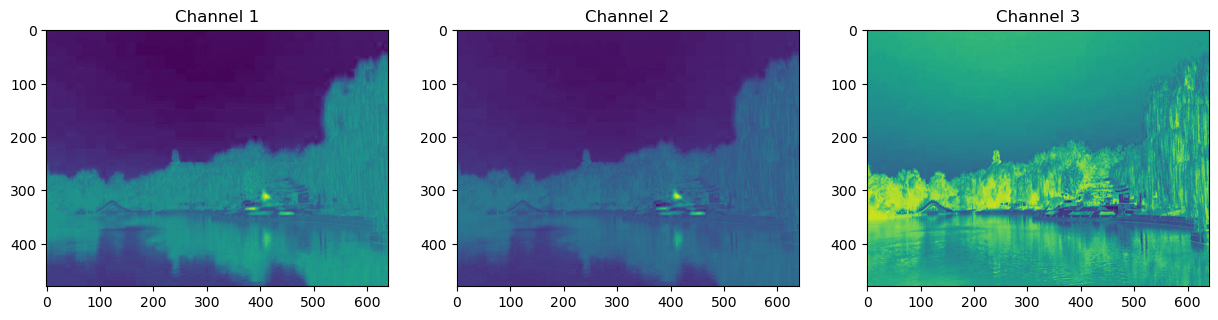

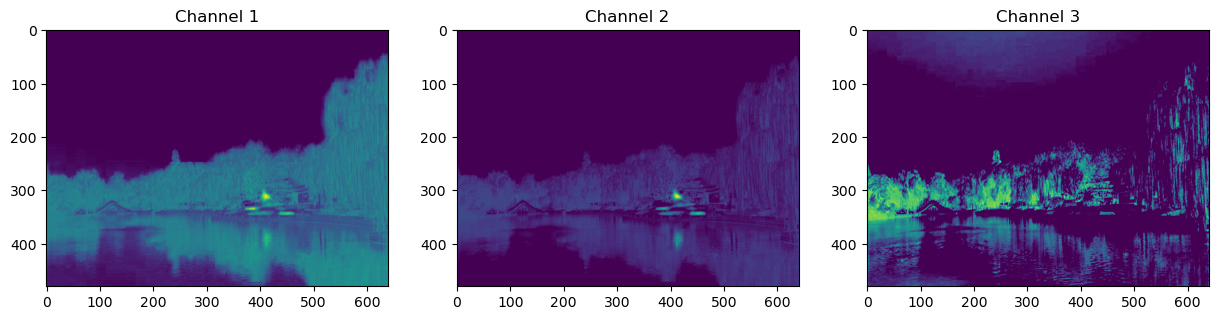

conv1.shape:(1, 3, 480, 640)
relu1.shape:(1, 3, 480, 640)


In [22]:
# array_show(hazy_image)
conv1 = conv2d(hazy_image, w_conv1, b_conv1, conv1_shape, stride=1, padding='SAME')
# array_show(conv1)
visualize_channels(conv1)
relu1 = Relu(conv1)
# array_show(relu1)
visualize_channels(relu1)

print(f"conv1.shape:{conv1.shape}")
print(f"relu1.shape:{relu1.shape}")

In [23]:
print(f"conv1:{conv1}")
print(f"conv1.shape:{conv1.shape}")

conv1:[[[[-4.14200613e-02 -4.14200613e-02 -4.14200613e-02 ... -3.49039281e-02
    -3.49039281e-02 -3.49039281e-02]
   [-4.14200613e-02 -4.14200613e-02 -4.14200613e-02 ... -3.49039281e-02
    -3.49039281e-02 -3.49039281e-02]
   [-4.14200613e-02 -4.14200613e-02 -4.14200613e-02 ... -3.49039281e-02
    -3.49039281e-02 -3.49039281e-02]
   ...
   [ 4.88990611e-02  4.76994962e-02  4.64999314e-02 ...  2.75869147e-01
     2.91463489e-01  3.01060008e-01]
   [ 4.88990611e-02  4.64999314e-02  4.53003666e-02 ...  2.74669582e-01
     2.90263925e-01  2.99860443e-01]
   [ 4.88990611e-02  4.64999314e-02  4.53003666e-02 ...  2.73470017e-01
     2.89064360e-01  2.98660878e-01]]

  [[-9.58496437e-02 -9.58496437e-02 -9.58496437e-02 ... -8.67094292e-02
    -8.67094292e-02 -8.67094292e-02]
   [-9.58496437e-02 -9.58496437e-02 -9.58496437e-02 ... -8.67094292e-02
    -8.67094292e-02 -8.67094292e-02]
   [-9.58496437e-02 -9.58496437e-02 -9.58496437e-02 ... -8.67094292e-02
    -8.67094292e-02 -8.67094292e-02]
   .

In [6]:
print(f"relu1:{relu1}")
print(f"relu1.shape:{relu1.shape}")

relu1:[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.04889906 0.0476995  0.04649993 ... 0.27586915 0.29146349
    0.30106001]
   [0.04889906 0.04649993 0.04530037 ... 0.27466958 0.29026392
    0.29986044]
   [0.04889906 0.04649993 0.04530037 ... 0.27347002 0.28906436
    0.29866088]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.07703894 0.08893565
    0.09625671]
   [0.         0.         0.         ... 0.07612381 0.08802052
    0.09534157]
   [0.         0.         0.         ... 0.07520867 0.08710539
    0.09442644]]

  [[0.01900888 0.01900888 0.01900888 ... 0.         0.
    0.        ]
   [0

第二层卷积和ReLU

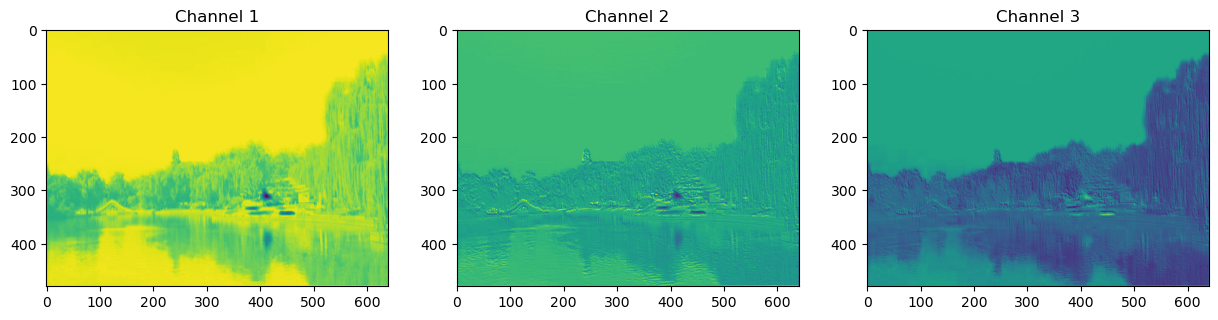

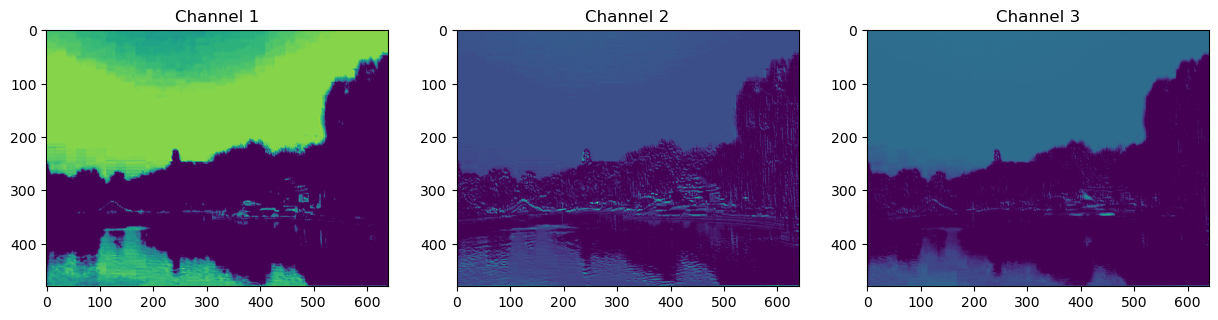

In [24]:
#filter_shape=(output_channel,input_channel,filter_size)
#               输出通道数      输入通道数     卷积核大小
conv2 = conv2d(relu1, w_conv2, b_conv2, conv2_shape, stride=1, padding='SAME')
visualize_channels(conv2)
# array_show(conv2)
relu2 = Relu(conv2)
visualize_channels(relu2)
# array_show(relu2)

In [8]:
print(f"conv2:{conv2}")
print(f"conv2.shape:{conv2.shape}")

conv2:[[[[ 0.06846791  0.06627964  0.06627964 ...  0.06817713  0.06817713
     0.06817713]
   [ 0.066356    0.05914777  0.05914777 ...  0.06817713  0.06817713
     0.06817713]
   [ 0.066356    0.05914777  0.05914777 ...  0.06817713  0.06817713
     0.06817713]
   ...
   [ 0.05318676  0.02633312  0.02913329 ... -0.14586539 -0.15140119
    -0.20303436]
   [ 0.0529292   0.02780209  0.0302085  ... -0.14800194 -0.15403626
    -0.20687566]
   [ 0.07017638  0.05851484  0.05913252 ...  0.03057572  0.03529203
    -0.03677467]]

  [[ 0.04415065  0.04158979  0.04158979 ...  0.05108311  0.05108311
     0.05108311]
   [ 0.05367124  0.0551015   0.0551015  ...  0.05108311  0.05108311
     0.05108311]
   [ 0.05367124  0.0551015   0.0551015  ...  0.05108311  0.05108311
     0.05108311]
   ...
   [ 0.06206205  0.05648201  0.05533755 ... -0.01508255 -0.02468779
    -0.16176054]
   [ 0.05786981  0.05102185  0.0497725  ... -0.01064719 -0.0164314
    -0.15364719]
   [ 0.08548763  0.10571794  0.10050311 ... 

In [9]:
print(f"relu2:{relu2}")
print(f"relu2.shape:{relu2.shape}")

relu2:[[[[0.06846791 0.06627964 0.06627964 ... 0.06817713 0.06817713
    0.06817713]
   [0.066356   0.05914777 0.05914777 ... 0.06817713 0.06817713
    0.06817713]
   [0.066356   0.05914777 0.05914777 ... 0.06817713 0.06817713
    0.06817713]
   ...
   [0.05318676 0.02633312 0.02913329 ... 0.         0.
    0.        ]
   [0.0529292  0.02780209 0.0302085  ... 0.         0.
    0.        ]
   [0.07017638 0.05851484 0.05913252 ... 0.03057572 0.03529203
    0.        ]]

  [[0.04415065 0.04158979 0.04158979 ... 0.05108311 0.05108311
    0.05108311]
   [0.05367124 0.0551015  0.0551015  ... 0.05108311 0.05108311
    0.05108311]
   [0.05367124 0.0551015  0.0551015  ... 0.05108311 0.05108311
    0.05108311]
   ...
   [0.06206205 0.05648201 0.05533755 ... 0.         0.
    0.        ]
   [0.05786981 0.05102185 0.0497725  ... 0.         0.
    0.        ]
   [0.08548763 0.10571794 0.10050311 ... 0.16871814 0.18418588
    0.12048501]]

  [[0.10145488 0.09480878 0.09480878 ... 0.09773736 0.097737

Concat1

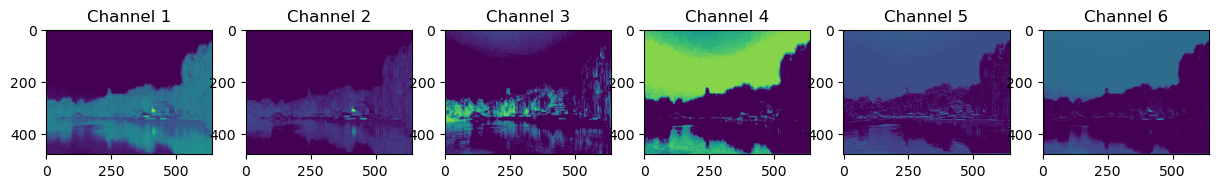

concat1:[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.04889906 0.0476995  0.04649993 ... 0.27586915 0.29146349
    0.30106001]
   [0.04889906 0.04649993 0.04530037 ... 0.27466958 0.29026392
    0.29986044]
   [0.04889906 0.04649993 0.04530037 ... 0.27347002 0.28906436
    0.29866088]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.07703894 0.08893565
    0.09625671]
   [0.         0.         0.         ... 0.07612381 0.08802052
    0.09534157]
   [0.         0.         0.         ... 0.07520867 0.08710539
    0.09442644]]

  [[0.01900888 0.01900888 0.01900888 ... 0.         0.
    0.        ]
   

In [25]:
concat1 = concat(relu1,relu2)
visualize_channels(concat1)
print(f"concat1:{concat1}")
print(f"concat1.shape:{concat1.shape}")

第三层卷积和ReLU

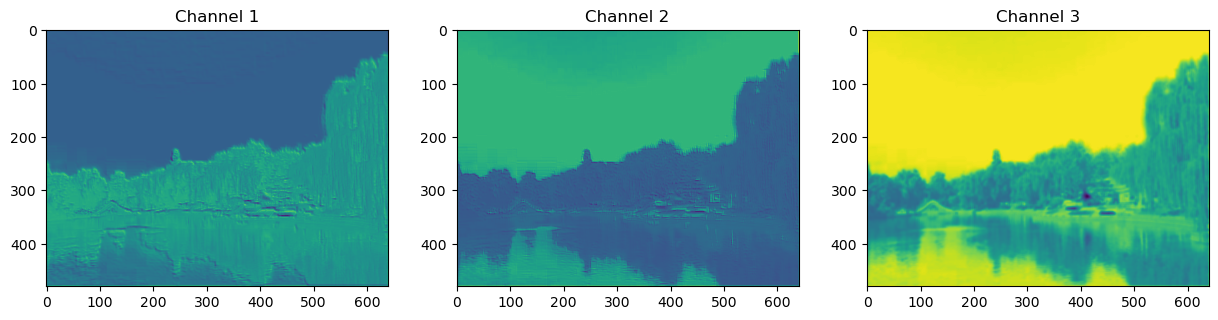

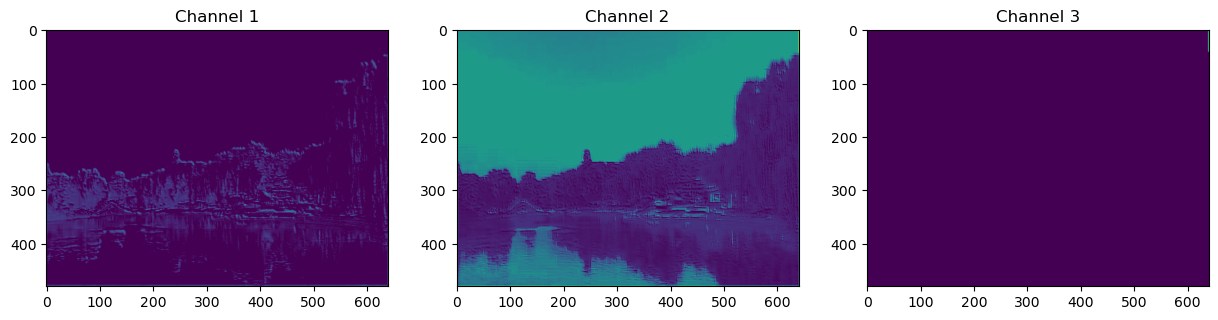

In [26]:
#filter_shape=(output_channel,input_channel,filter_size)
#               输出通道数      输入通道数     卷积核大小
conv3 = conv2d(concat1, w_conv3, b_conv3, conv3_shape, stride=1, padding='SAME')
visualize_channels(conv3)
# array_show(conv3)
relu3 = Relu(conv3)
visualize_channels(relu3)
# array_show(relu3)

Concat2

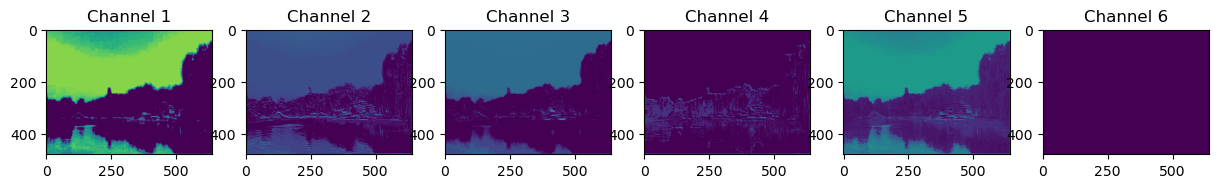

concat2:[[[[0.06846791 0.06627964 0.06627964 ... 0.06817713 0.06817713
    0.06817713]
   [0.066356   0.05914777 0.05914777 ... 0.06817713 0.06817713
    0.06817713]
   [0.066356   0.05914777 0.05914777 ... 0.06817713 0.06817713
    0.06817713]
   ...
   [0.05318676 0.02633312 0.02913329 ... 0.         0.
    0.        ]
   [0.0529292  0.02780209 0.0302085  ... 0.         0.
    0.        ]
   [0.07017638 0.05851484 0.05913252 ... 0.03057572 0.03529203
    0.        ]]

  [[0.04415065 0.04158979 0.04158979 ... 0.05108311 0.05108311
    0.05108311]
   [0.05367124 0.0551015  0.0551015  ... 0.05108311 0.05108311
    0.05108311]
   [0.05367124 0.0551015  0.0551015  ... 0.05108311 0.05108311
    0.05108311]
   ...
   [0.06206205 0.05648201 0.05533755 ... 0.         0.
    0.        ]
   [0.05786981 0.05102185 0.0497725  ... 0.         0.
    0.        ]
   [0.08548763 0.10571794 0.10050311 ... 0.16871814 0.18418588
    0.12048501]]

  [[0.10145488 0.09480878 0.09480878 ... 0.09773736 0.0977

In [27]:
concat2 = concat(relu2,relu3)
visualize_channels(concat2)
print(f"concat2:{concat2}")
print(f"concat2.shape:{concat2.shape}")

第四层卷积核ReLU

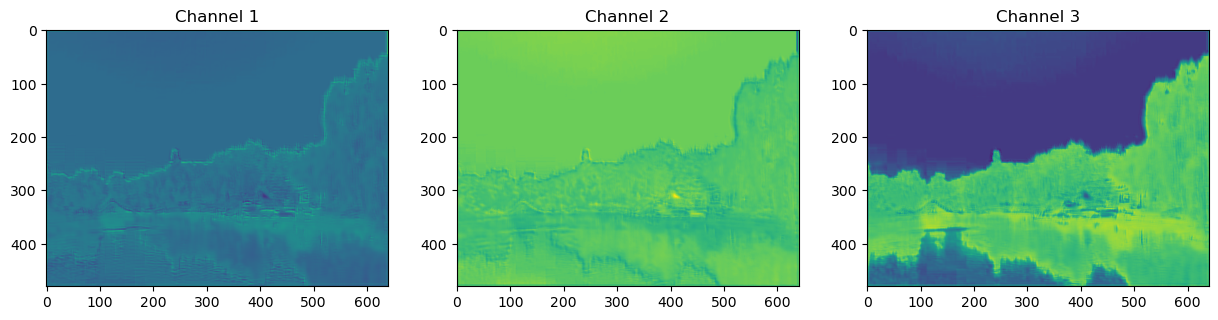

deahze_img.shape:(1, 3, 480, 640)
deahze_img.shape after:(3, 480, 640)


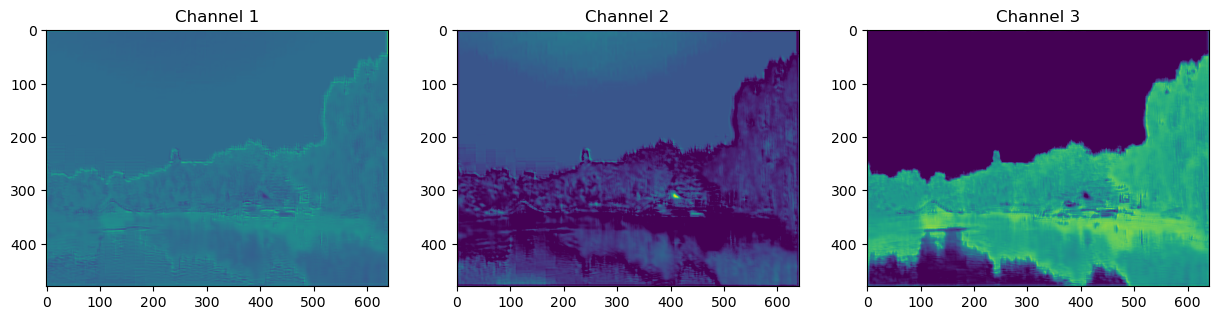

deahze_img.shape:(1, 3, 480, 640)
deahze_img.shape after:(3, 480, 640)


In [28]:
#filter_shape=(output_channel,input_channel,filter_size)
#               输出通道数      输入通道数     卷积核大小
conv4 = conv2d(concat2, w_conv4, b_conv4, conv4_shape, stride=1, padding='SAME')
visualize_channels(conv4)
array_show(conv4)
relu4 = Relu(conv4)
visualize_channels(relu4)
array_show(relu4)

Concat3

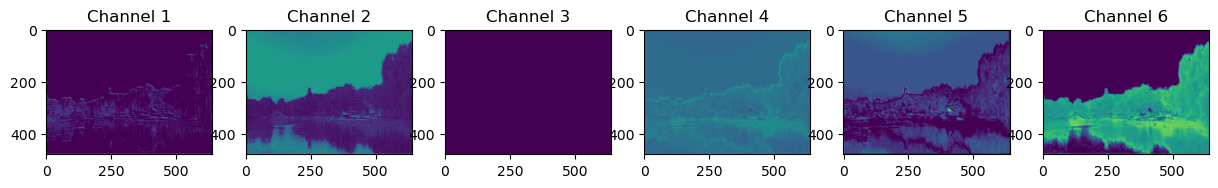

concat3:[[[[0.07091696 0.         0.         ... 0.         0.
    0.        ]
   [0.06882969 0.         0.         ... 0.         0.
    0.        ]
   [0.1418773  0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.06904369 0.         0.         ... 0.         0.
    0.        ]
   [0.23661598 0.07454877 0.10086195 ... 0.09595575 0.05126261
    0.05368891]
   [0.08428235 0.         0.         ... 0.         0.
    0.        ]]

  [[0.22191449 0.26905179 0.26225561 ... 0.26706074 0.21545913
    0.28407961]
   [0.22259087 0.29022622 0.27248331 ... 0.3022654  0.24711764
    0.34828789]
   [0.15137271 0.21853218 0.16770409 ... 0.1895355  0.16727498
    0.3442574 ]
   ...
   [0.1728406  0.15986738 0.10142844 ... 0.01062081 0.03455605
    0.0978776 ]
   [0.16630951 0.1523927  0.10869318 ... 0.03611145 0.01974295
    0.09847842]
   [0.23730514 0.26575117 0.25242638 ... 0.12823065 0.09842885
    0.1981782 ]]

  [[0.         0.         0.         ... 0.24872981 0.29963559
   

In [29]:
concat3 = concat(relu3,relu4)
visualize_channels(concat3)
print(f"concat3:{concat3}")
print(f"concat3.shape:{concat3.shape}")

第五层卷积和ReLU

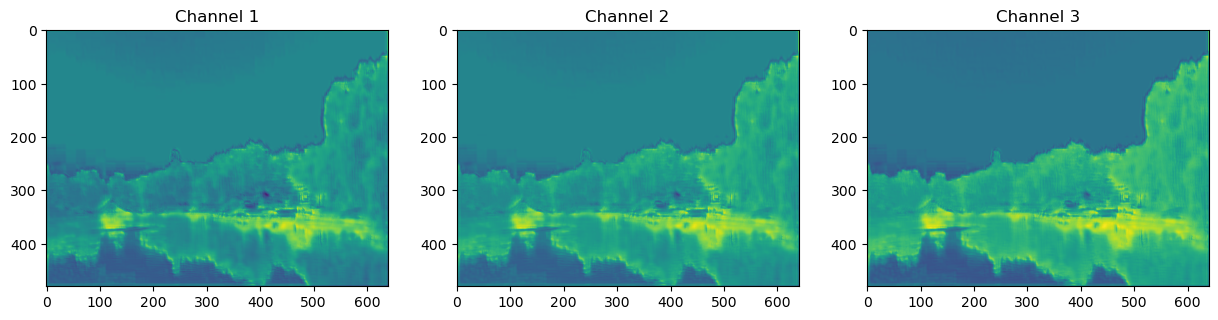

deahze_img.shape:(1, 3, 480, 640)
deahze_img.shape after:(3, 480, 640)


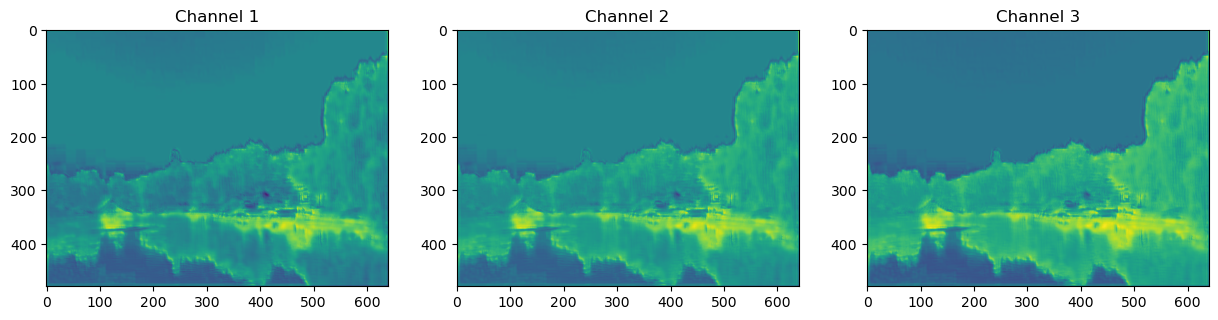

deahze_img.shape:(1, 3, 480, 640)
deahze_img.shape after:(3, 480, 640)


In [30]:
#filter_shape=(output_channel,input_channel,filter_size)
#               输出通道数      输入通道数     卷积核大小
conv5 = conv2d(concat3, w_conv5, b_conv5, conv5_shape, stride=1, padding='SAME')
visualize_channels(conv5)
array_show(conv5)
relu5 = Relu(conv5)
visualize_channels(relu5)
array_show(relu5)

图像后处理

out_mul:[[[[0.55878808 0.62362609 0.67522401 ... 0.73640698 0.78813619
    0.68718845]
   [0.62043327 0.68605743 0.69161756 ... 0.79988162 0.80615058
    0.83212091]
   [0.65543501 0.67044842 0.68797308 ... 0.78504719 0.8074213
    0.82328667]
   ...
   [0.60976285 0.60756939 0.62034337 ... 0.61835035 0.56564357
    0.49439073]
   [0.60938437 0.62698887 0.64061626 ... 0.62450007 0.56845668
    0.48359417]
   [0.53248515 0.58571034 0.59879203 ... 0.56632369 0.50554048
    0.45972932]]

  [[0.67481507 0.82125963 0.85611244 ... 0.89567374 0.88478863
    0.88445282]
   [0.74719252 0.87575937 0.87462988 ... 0.98726165 0.96138929
    1.06778813]
   [0.80626816 0.8808677  0.87707634 ... 0.95188052 0.93721039
    1.08452949]
   ...
   [0.75608512 0.75284169 0.75896934 ... 0.64887725 0.56938518
    0.50674578]
   [0.71736367 0.75608613 0.78474833 ... 0.65543358 0.57748854
    0.51739071]
   [0.71063827 0.69161591 0.75713471 ... 0.58567848 0.51439564
    0.44546356]]

  [[0.71713521 0.89845743 0

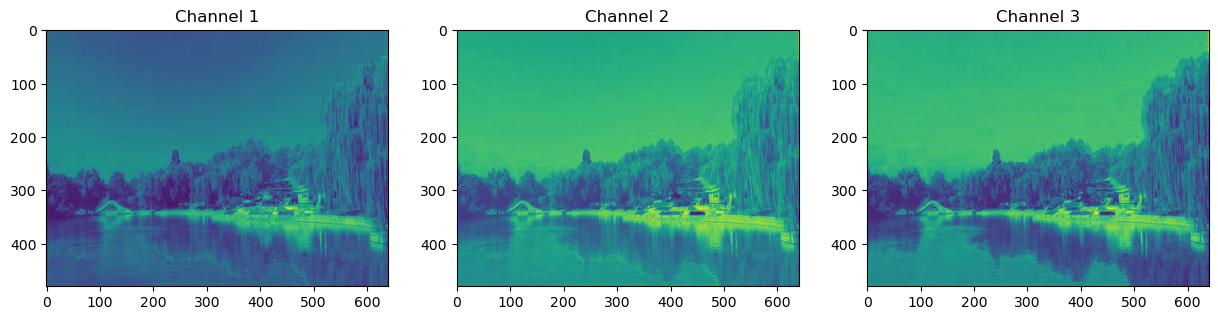

deahze_img.shape:(1, 3, 480, 640)
deahze_img.shape after:(3, 480, 640)


In [31]:
out_mul = relu5 * hazy_image
print(f"out_mul:{out_mul}")
print(f"out_mul.shape:{out_mul.shape:}")
visualize_channels(out_mul)
array_show(out_mul)

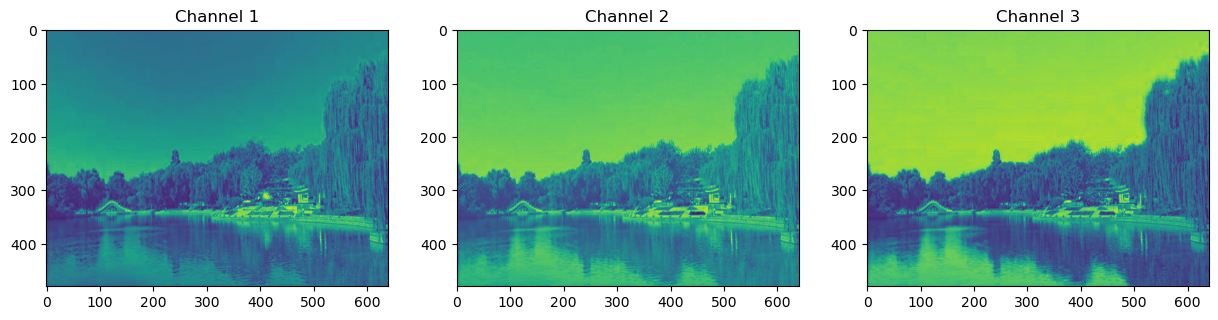

deahze_img.shape:(1, 3, 480, 640)
deahze_img.shape after:(3, 480, 640)
out_sub:[[[[-0.45178611 -0.50420832 -0.5459258  ... -0.48296822 -0.51689451
    -0.45068853]
   [-0.5016269  -0.55468473 -0.55918016 ... -0.52459769 -0.52870915
    -0.54574164]
   [-0.52992618 -0.54206468 -0.55623356 ... -0.51486861 -0.52954254
    -0.53994775]
   ...
   [-0.62428101 -0.6123534  -0.61549694 ... -0.61351948 -0.68860956
    -0.68383017]
   [-0.62389352 -0.62209052 -0.6257182  ... -0.60997681 -0.68116792
    -0.6582254 ]
   [-0.54516337 -0.58113448 -0.58486664 ... -0.54454201 -0.59627851
    -0.61578422]]

  [[-0.25533543 -0.31074689 -0.32393444 ... -0.30012104 -0.29647368
    -0.29636115]
   [-0.28272149 -0.33136841 -0.33094104 ... -0.33081019 -0.32214091
    -0.35779288]
   [-0.30507444 -0.33330129 -0.33186672 ... -0.31895473 -0.31403908
    -0.36340255]
   ...
   [-0.45650422 -0.44699975 -0.44312496 ... -0.59521071 -0.64055833
    -0.64700578]
   [-0.43312523 -0.44144159 -0.45050367 ... -0.59184674

In [34]:
out_sub = out_mul - relu5
visualize_channels(out_sub)
array_show(out_sub)
print(f"out_sub:{out_sub}")
print(f"out_sub.shape:{out_sub.shape:}")

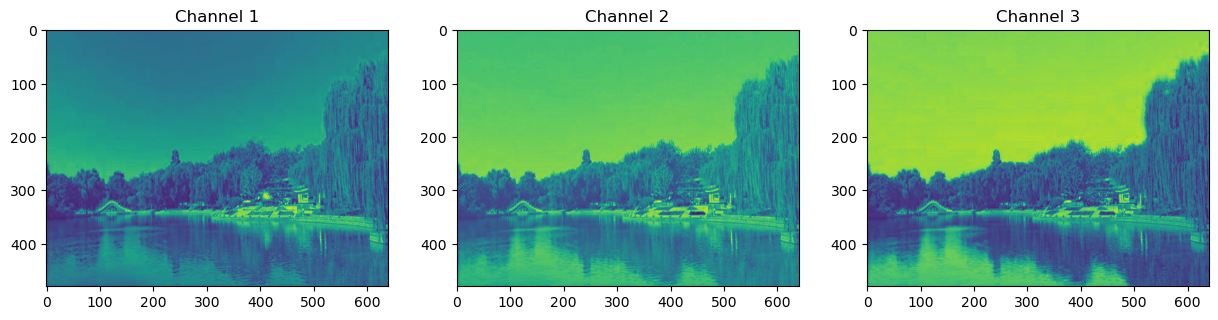

deahze_img.shape:(1, 3, 480, 640)
deahze_img.shape after:(3, 480, 640)
out_add:[[[[0.54821389 0.49579168 0.4540742  ... 0.51703178 0.48310549
    0.54931147]
   [0.4983731  0.44531527 0.44081984 ... 0.47540231 0.47129085
    0.45425836]
   [0.47007382 0.45793532 0.44376644 ... 0.48513139 0.47045746
    0.46005225]
   ...
   [0.37571899 0.3876466  0.38450306 ... 0.38648052 0.31139044
    0.31616983]
   [0.37610648 0.37790948 0.3742818  ... 0.39002319 0.31883208
    0.3417746 ]
   [0.45483663 0.41886552 0.41513336 ... 0.45545799 0.40372149
    0.38421578]]

  [[0.74466457 0.68925311 0.67606556 ... 0.69987896 0.70352632
    0.70363885]
   [0.71727851 0.66863159 0.66905896 ... 0.66918981 0.67785909
    0.64220712]
   [0.69492556 0.66669871 0.66813328 ... 0.68104527 0.68596092
    0.63659745]
   ...
   [0.54349578 0.55300025 0.55687504 ... 0.40478929 0.35944167
    0.35299422]
   [0.56687477 0.55855841 0.54949633 ... 0.40815326 0.36046724
    0.34982761]
   [0.57093539 0.5961994  0.56534859

In [35]:
out_add = out_sub+1
visualize_channels(out_add)
array_show(out_add)
print(f"out_add:{out_add}")
print(f"out_add.shape:{out_add.shape:}")